In [12]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import import_ipynb
import gibbs_sampler
import kl_divergence_calculator
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F  #for the activation function

In [13]:
"""
I will create two datasets of one dimensional gaussian. Pass it through separate VAE. Do Gibbs sampling and see 
if I can learn true latent space
""" 

def sample(mu, var, nb_samples):
    """
    :param mu: torch.Tensor (features)
    :param var: torch.Tensor (features) (note: zero covariance)
    :return: torch.Tensor (nb_samples, features)
    """
    out = []
    for i in range(nb_samples):
        out += [torch.normal(mu, var.sqrt())]
    return torch.stack(out, dim=0)

In [14]:
## Creating synthetic datasets
nb_samples=5000
mu1  =torch.tensor(1.)   # . converts long to float
var1 =torch.tensor(2.1)
mu2  =torch.tensor(2.)   # . converts long to float
var2 =torch.tensor(3.1)

inp_data1=sample(mu1,var1,nb_samples)
inp_data1=inp_data1.unsqueeze(0)
inp_data1=torch.transpose(inp_data1,0,1)

inp_data2=sample(mu2,var2,nb_samples)
inp_data2=inp_data2.unsqueeze(0)
inp_data2=torch.transpose(inp_data2,0,1)

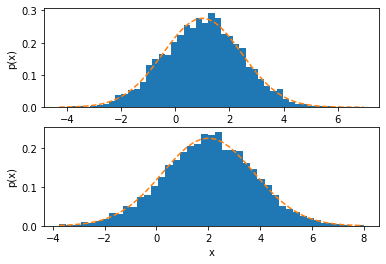

mu1 tensor(1.)
var1 tensor(2.1000)
mu2 tensor(2.)
var2 tensor(3.1000)


In [15]:
## for data visualization
data_vis1=inp_data1.numpy()
data_vis2=inp_data2.numpy()

fig, ax = plt.subplots(2,1)

#flg,(ax1,ax2)=plt.subplots(1,2,figsize=(6, 2))
#Panel a
n1,bins1,patches1=ax[0].hist(data_vis1,'auto',density=1)
y1=1/(np.sqrt(2*np.pi*var1))*np.exp(-0.5*(bins1-mu1.numpy())**2/var1)
ax[0].plot(bins1,y1,'--')
ax[0].set(xlabel='x',ylabel='p(x)')
#Panel b
n2,bins2,patches2=ax[1].hist(data_vis2,'auto',density=1)
y2=1/(np.sqrt(2*np.pi*var2))*np.exp(-0.5*(bins2-mu2.numpy())**2/var2)
ax[1].plot(bins2,y2,'--')
ax[1].set(xlabel='x',ylabel='p(x)')

plt.show()
print("mu1",mu1)
print("var1",var1)
print("mu2",mu2)
print("var2",var2)

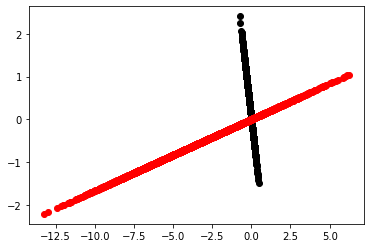

In [16]:
## Transforming data to a higher dimension
"""
inp_data= samplesx1
fun_A   = 1xdim_exp
data    = samplesxdim_exp   (data = inp_dataxfun_A)
"""
dim_exp = 2 
fun_A1   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
fun_A2   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
data1    = inp_data1*fun_A1
data2    = inp_data2*fun_A2
x1_cord = data1[:,0]
y1_cord = data1[:,1]
x2_cord = data2[:,0]
y2_cord = data2[:,1]
plt.plot(x1_cord,y1_cord, 'o', color='black')
plt.plot(x2_cord,y2_cord, 'o', color='red')
plt.show()

In [17]:
## Hyperparameters
epochs     = 500
batch_size = 128
lr         = 1e-4
device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
## Creating synthetic dataloader

train_loader_set1 = DataLoader(
    data1[0:int(0.8*nb_samples),],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
test_loader_set1 = DataLoader(
    data1[int(0.8*nb_samples):,],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
train_loader_set2 = DataLoader(
    data2[0:int(0.8*nb_samples),],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
test_loader_set2 = DataLoader(
    data2[int(0.8*nb_samples):,],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

In [19]:
## Neural net is like: [mu,logvar]=(relu(xA))B,x=sig((relu(zC))D)

latent_dim1 = 1
latent_dim2 = 1
        
class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        self.gibbs                   = gibbs_sampler.gibbs_sampler()  
        self.kl_div                  = kl_divergence_calculator.kl_divergence()
        ## Encoder set1
        self.set1_enc1 = nn.Linear(in_features = dim_exp,out_features = 2*latent_dim1)
        self.set1_enc2 = nn.Linear(in_features = 2*latent_dim1,out_features = 2*latent_dim1)
        ## Encoder set2
        self.set2_enc1 = nn.Linear(in_features = dim_exp,out_features = 2*latent_dim2)
        self.set2_enc2 = nn.Linear(in_features = 2*latent_dim2,out_features = 2*latent_dim2)
        ## Decoder set1
        self.set1_dec1 = nn.Linear(in_features = latent_dim1,out_features = dim_exp,bias=False)
        ## Decoder set2
        self.set2_dec1 = nn.Linear(in_features = latent_dim2,out_features = dim_exp,bias=False)
        self.register_parameter(name='g11', param = nn.Parameter(torch.randn(latent_dim1,latent_dim1)))
        self.register_parameter(name='g22', param = nn.Parameter(torch.randn(latent_dim2,latent_dim2)))
    def forward(self,x1,x2):
        data1    = x1
        data2    = x2
        ## encoding
        x1       = F.relu(self.set1_enc1(x1))
        x1       = self.set1_enc2(x1)
        x2       = F.relu(self.set2_enc1(x2))
        x2       = self.set2_enc2(x2)
        mu1      = x1[:,0]
        mu1      = mu1.unsqueeze(0)
        mu1      = torch.transpose(mu1,0,1)    
        log_var1 = x1[:,1]
        var1     = torch.exp(log_var1)
        var1     = var1.unsqueeze(0)
        var1     = torch.transpose(var1,0,1)    
        mu2      = x2[:,0]
        mu2      = mu2.unsqueeze(0)
        mu2      = torch.transpose(mu2,0,1)    
        log_var2 = x2[:,1]
        var2     = torch.exp(log_var2)
        var2     = var2.unsqueeze(0)
        var2     = torch.transpose(var2,0,1) 
#        G,z1,z2,z1_prior,z2_prior = self.gibbs.calc(mu1,var1,mu2,var2)
        G,z1,z2,z1_prior,z2_prior = self.gibbs.calc(mu1,var1,mu2,var2,self.g11,self.g22)
        part_fun0,part_fun1,part_fun2 = self.kl_div.calc(G,z1,z2,z1_prior,z2_prior,mu1,var1,mu2,var2)
        ## decoding

        reconstruction1=self.set1_dec1(z1)
        reconstruction2=self.set2_dec1(z2)
        
        ## loss
        mse_loss = nn.MSELoss(reduction='sum')
        MSE1 = mse_loss(reconstruction1, data1)
        MSE2 = mse_loss(reconstruction2, data2)
        KLD = part_fun0+part_fun1+part_fun2
        loss= MSE1+MSE2+KLD
        return mu1,log_var1,mu2,log_var2,loss
    
    

In [20]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(),lr=lr)
for name, para in model.named_parameters():
    print(name)

g11
g22
set1_enc1.weight
set1_enc1.bias
set1_enc2.weight
set1_enc2.bias
set2_enc1.weight
set2_enc1.bias
set2_enc2.weight
set2_enc2.bias
set1_dec1.weight
set2_dec1.weight


In [21]:
def train(model,dataloader1,dataloader2):
    model.train()
    running_loss = 0
    for i,(data1,data2) in enumerate(zip(dataloader1,dataloader2)):
        data1                        = data1.to(device)
        data2                        = data2.to(device)        
        mu1,log_var1,mu2,log_var2,loss = model(data1,data2)     
        running_loss                += loss.item()
        loss.backward() 
        optimizer.step()
    #print(len(dataloader1.dataset)+len(dataloader2.dataset))

    train_loss = running_loss/(len(dataloader1.dataset)+len(dataloader2.dataset))
    return train_loss
def test(model,dataloader1,dataloader2):
    mean1_pred = []
    var1_pred  = []
    mean2_pred = []
    var2_pred  = []
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i,(data1,data2) in enumerate(zip(dataloader1,dataloader2)):
            data1                        = data1.to(device)
            data2                        = data2.to(device)        
            mu1,log_var1,mu2,log_var2,loss = model(data1,data2)  
            running_loss              += loss.item()
            mean1_pred                += [torch.mean(mu1)]
            var1_pred                 += [torch.mean(torch.exp(log_var1))]
            mean2_pred                += [torch.mean(mu2)]
            var2_pred                 += [torch.mean(torch.exp(log_var2))]
    test_loss   = running_loss/(len(dataloader1.dataset)+len(dataloader2.dataset))
    mean1_pred  = torch.stack(mean1_pred,dim=0)
    var1_pred   = torch.stack(var1_pred,dim=0)
    mean1_pred  = torch.mean(mean1_pred)
    var1_pred   = torch.mean(var1_pred)
    
    mean2_pred  = torch.stack(mean2_pred,dim=0)
    var2_pred   = torch.stack(var2_pred,dim=0)
    mean2_pred  = torch.mean(mean2_pred)
    var2_pred   = torch.mean(var2_pred)
    return test_loss,mean1_pred,var1_pred,mean2_pred,var2_pred

In [22]:
train_loss = []
test_loss = []
for epoch in range(epochs):
    #print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model,train_loader_set1,train_loader_set2)
    test_epoch_loss,mean1_pred,var1_pred,mean2_pred,var2_pred = test(model,test_loader_set1,test_loader_set1)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
print(f"Train Loss    : {train_epoch_loss:.4f}")
print(f"Test Loss     :  {test_epoch_loss:.4f}")
print(f"Mean Pred set1:  {mean1_pred:.4f}")
print(f"Var  Pred set1:  {var1_pred:.4f}")
print(f"Mean Pred set2:  {mean2_pred:.4f}")
print(f"Var  Pred set2:  {var2_pred:.4f}")

Train Loss    : 10.2634
Test Loss     :  0.6242
Mean Pred set1:  -0.9995
Var  Pred set1:  75248.1797
Mean Pred set2:  1.0955
Var  Pred set2:  25.2479


In [12]:
for name, para in model.named_parameters():
    print(para)

Parameter containing:
tensor([[0.0372]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[0.5926]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.8551,  0.7992],
        [ 0.2070, -0.5500]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.5014, -1.1681], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[0.3627, 0.2095],
        [1.0822, 0.8344]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([1.2403, 2.5376], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.8176, -0.7067],
        [ 0.2797, -0.1044]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.0218, -0.5470], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 1.1860,  0.2242],
        [-1.1127,  0.0869]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 1.8814, -1.1929], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0658],
 

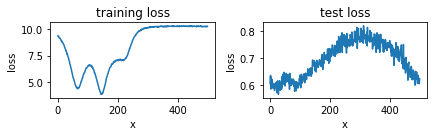

In [23]:
flg,(ax1,ax2)=plt.subplots(1,2,figsize=(6, 2))
ax1.plot(train_loss)
ax1.set(xlabel='x',ylabel='loss',title='training loss')
ax2.plot(test_loss)
ax2.set(xlabel='x',ylabel='loss',title='test loss')
flg.tight_layout()
plt.show()

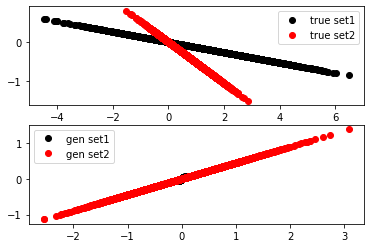

In [13]:
## Transforming data to a higher dimension
mean_pred  =torch.tensor(0.).cpu()   # . converts long to float
var_pred =torch.tensor(1.0).cpu()
gen_data  = sample(mean_pred,var_pred,nb_samples)
gen_data  = gen_data.unsqueeze(1)

"""
inp_data= samplesx1
fun_A   = 1xdim_exp
data    = samplesxdim_exp   (data = inp_dataxfun_A)
"""
#fun_A   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
param_dict={}
for name, para in model.named_parameters():
    param_dict[name]=para

A1=param_dict["set1_dec1.weight"]
A2=param_dict["set2_dec1.weight"]
set1_dec1_wgt=A1
set2_dec1_wgt=A2
set1_dec1_wgt  = (torch.transpose(set1_dec1_wgt,0,1)).cpu()
set2_dec1_wgt  = (torch.transpose(set2_dec1_wgt,0,1)).cpu()

data1_sim= gen_data*set1_dec1_wgt
data2_sim= gen_data*set2_dec1_wgt

dat1_x_cord = data1_sim[:,0].cpu().detach().numpy()
dat1_y_cord = data1_sim[:,1].cpu().detach().numpy()
dat2_x_cord = data2_sim[:,0].cpu().detach().numpy()
dat2_y_cord = data2_sim[:,1].cpu().detach().numpy()

fig, ax = plt.subplots(2)

ax[0].plot(x1_cord,y1_cord, 'o', color='black',label='true set1')
ax[0].plot(x2_cord,y2_cord, 'o', color='red',label='true set2')
ax[0].legend()
ax[1].plot(dat1_x_cord,dat1_y_cord, 'o', color='black',label='gen set1')
ax[1].plot(dat2_x_cord,dat2_y_cord, 'o', color='red',label='gen set2')
ax[1].legend()
plt.show()

In [13]:
A= list(model.parameters())
A

[Parameter containing:
 tensor([[ 0.3634, -0.1517],
         [-0.2335, -0.4447]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.7149, -0.4630], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-0.5454, -0.1855],
         [ 0.5248,  0.1178]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.2600, 0.4946], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.4787,  0.6989],
         [-0.0583, -0.1685]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.4793, 0.4292], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-0.0215,  0.1835],
         [ 0.0858,  0.3211]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.7034, -0.0446], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[0.0180],
         [0.4767]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-0.0741],
         [-0.2888]], devi

In [16]:
sample_dict={}
for name, para in model.named_parameters():
    sample_dict[name]=para

set1_enc1.weight
set1_enc1.bias
set1_enc2.weight
set1_enc2.bias
set2_enc1.weight
set2_enc1.bias
set2_enc2.weight
set2_enc2.bias
set1_dec1.weight
set2_dec1.weight


In [180]:
sample_dict["set1_enc1.weight"]

Parameter containing:
tensor([[ 0.2454,  0.5722],
        [ 0.3943, -0.1476]], device='cuda:0', requires_grad=True)

In [181]:
model.named_parameters()

<generator object Module.named_parameters at 0x7f93e4295580>

'set2_dec1.weight'